$$
\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}
$$

$$
\begin{equation}
F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)
\end{equation}
$$



$$
\begin{equation}
\rho(x,0) = \left\{
\begin{array}{cc}
0.5 \rho_{\rm max} & 0 \leq x < 3  \\
\rho_{\rm max} & 3 \leq x \leq 4 \\
\end{array}
\right.
\end{equation}
$$


\begin{align}
&\rho_i^{n+1} = \rho_i^n - \frac{\Delta t}{2 \Delta x} \left(F^n_{i+1}-F^n_{i-1}\right) + \cdots \\ \nonumber 
&+ \frac{(\Delta t)^2}{4(\Delta x)^2} \left[ (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right]
\end{align}

\begin{equation}J^n_i = \frac{\partial F}{\partial \rho} = u_{\rm max} \left(1-2\frac{\rho^n_i}{\rho_{\rm max}} \right).\end{equation} 

In [11]:
import sympy as sp


In [12]:
sp.init_printing()

In [13]:
(u_max, u_star, rho_max, rho_star, A, B)= sp.symbols('u_max u_star rho_max rho_star A B')

In [14]:
eq1 = sp.Eq(0, u_max*rho_max*(1-A*rho_max-B*rho_max**2))
eq2 = sp.Eq(0, u_max*(1-2*A*rho_star-3*B*rho_star**2))
eq3 = sp.Eq(u_star, u_max*(1-A*rho_star-B*rho_star**2))


In [15]:
eq1

In [16]:
eq2

In [17]:
eq3

In [18]:
eq4=sp.Eq(eq2.lhs-3*eq3.lhs, eq2.rhs-3*eq3.rhs)

In [19]:
eq4.expand()

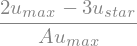

In [20]:
rho_sol=sp.solve(eq4, rho_star)[0]
rho_sol

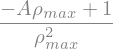

In [21]:
B_sol=sp.solve(eq1, B)[0]
B_sol

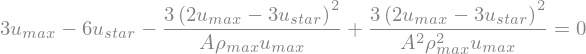

In [22]:
quadA=eq2.subs([(rho_star, rho_sol), (B, B_sol)])
quadA.simplify()

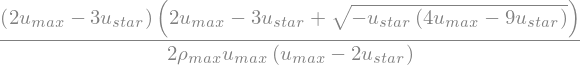

In [23]:
A_sol=sp.solve(quadA, A)
A_sol[1]

In [24]:
A_val_0=A_sol[0].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_0

In [25]:
A_val_1=A_sol[1].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_1

In [26]:
A_val=max(A_val_0, A_val_1)

In [27]:
B_val=B_sol.evalf(subs={A:A_val, rho_max:10.0})
B_val

In [28]:
sp.init_printing(use_latex=False)

In [53]:
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline 

In [54]:
np.set_printoptions(precision=3)
plt.style.use('dark_background')
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']='16'

In [78]:
def rho_green_light(x, rho_max):
    rho=rho_max*np.ones_like(x)
    mask=np.where(x<3.0)
    rho[mask]=rho_max/2.0
    return rho

In [79]:
nx=100
L=4.0
dx=L/nx
nt=30
CFL=np.array([0.1, 0.2, 0.3, 0.4, 1.0])
cases=np.size(CFL)
u_max=1.0
dt=CFL*dx/u_max
rho_max=10.0
rho_light=5.0
A=A_val
B=B_val
x=np.linspace(0.0 + 0.5*dx, L-0.5*dx, num=nx)
rho0=rho_green_light(x, rho_max)

(4.0, 11.0)

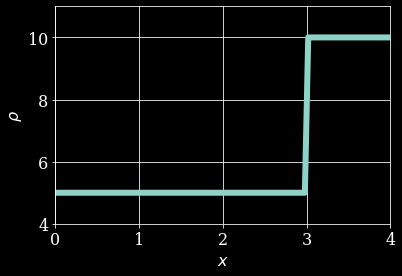

In [80]:
plt.figure(figsize=(6.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.grid()
plt.plot(x, rho0, color='C0', linestyle='-', linewidth=6)
plt.xlim(0.0, L)
plt.ylim(4, 11.0)

In [81]:
def flux(rho, u_max, rho_max, A, B):
    F=rho*u_max*(1-A*rho-B*rho**2)
    return F

In [82]:
def ftbs(rho1, u_max, rho_max, A, B, CFL0, nt, rho0):
    for n in range(nt-1):
        F=flux(rho1[n], u_max, rho_max, A, B)
        rho1[n+1, 0]=rho0[0]
        rho1[n+1, 1:]=rho1[n, 1:]-CFL0/u_max*(F[1:]-F[:-1])
    return rho1

In [83]:
def laxfriedrichs(rho1, u_max, rho_max, A, B, CFL0, nt, rho0):
    for n in range(nt-1):
        F=flux(rho1[n], u_max, rho_max, A, B)
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=0.5*(rho1[n,2:]+rho1[n, 0:-2])-0.5*CFL0*(F[2:]-F[0:-2])/u_max
    return rho1

In [84]:
def minmod (e, dx):
    sigma=np.zeros_like(e)
    for i in range (1, len(e)-1):
        de_minus = (e[i] - e[i - 1]) / dx
        de_plus = (e[i + 1] - e[i]) / dx
        if de_minus > 0 and de_plus > 0:
            sigma[i] = min(de_minus, de_plus)
        elif de_minus < 0 and de_plus < 0:
            sigma[i] = max(de_minus, de_plus)
        else:
            sigma[i] = 0.0
    return sigma

In [85]:
def compute_flux(rho):
    sigma=minmod(rho, dx)
    rhoL=rho[:-1]+sigma[:-1]*dx/2
    rhoR=rho[1:]-sigma[1:]*dx/2
    F=0.5*(flux1(rhoL, u_max, rho_max)+flux1(rhoR, u_max, rho_max)-u_max/CFL0*(rhoR-rhoL))
    return F

In [86]:
def Jacobian(rho1, u_max, rho_max, A, B):
    J=u_max*(1-2*A*rho1-3*B*rho1**2)
    return J

\begin{align}
&\rho_i^{n+1} = \rho_i^n - \frac{\Delta t}{2 \Delta x} \left(F^n_{i+1}-F^n_{i-1}\right) + \cdots \\ \nonumber 
&+ \frac{(\Delta t)^2}{4(\Delta x)^2} \left[ (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right]
\end{align}

In [87]:
def flux1(rho, u_max, rho_max):
    F=rho*u_max*(1-rho/rho_max)
    return F

In [88]:
def godunov (rho1, u_max, rho_max, CFL0, nt, rho0):
    for n in range(nt-1):
        rhoL=rho1[n,:-1]
        rhoR=rho1[n,1:]
        F=0.5*(flux1(rhoL, u_max, rho_max)+flux1(rhoR, u_max, rho_max)-u_max/CFL0*(rho1[n,1:]-rho1[n,:-1]))
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=rho1[n,1:-1]-CFL0/u_max*(F[1:]-F[:-1])
    return rho1

In [89]:
def MUSCL (rho1, u_max, rho_max, CFL0, nt, rho0):
    for n in range(nt-1):
        F=compute_flux(rho1[n,:])
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=rho1[n,1:-1]-CFL0/u_max*(F[1:]-F[:-1])
        
        F=compute_flux(rho1[n+1, :])
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=rho1[n+1,1:-1]-CFL0/u_max*(F[1:]-F[:-1])
        
    return rho1

In [90]:
def laxwendroff(rho1, u_max, rho_max, A, B, CFL0, nt, rho0):
    for n in range(nt-1):
        F=flux(rho1[n], u_max, rho_max, A, B)
        J=Jacobian(rho1[n], u_max, rho_max, A, B)
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=rho1[n, 1:-1]-CFL0*0.5/u_max*(F[2:]-F[0:-2])+0.25*(CFL0/u_max)**2*((J[2:]+J[1:-1])*(F[2:]-F[1:-1])-(J[1:-1]+J[0:-2])*(F[1:-1]-F[0:-2]))
    return rho1

$$
\begin{equation}
\rho^*_i = \rho^n_i - \frac{\Delta t}{\Delta x} (F^n_{i+1}-F^n_{i}) \ \ \ \ \ \ \text{(predictor)}
\end{equation}
$$


$$
\begin{equation}
\rho^{n+1}_i = \frac{1}{2} (\rho^n_i + \rho^*_i - \frac{\Delta t}{\Delta x} (F^*_i - F^{*}_{i-1})) \ \ \ \ \ \ \text{(corrector)}
\end{equation}
$$

In [91]:
def maccormack(rho1, u_max, rho_max, A, B, CFL0, nt, rho0):
    for n in range(nt-1):
        F=flux(rho1[n], u_max, rho_max, A, B)
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=rho1[n, 1:-1]-CFL0/u_max*(F[2:]-F[1:-1])
        F1=flux(rho1[n+1], u_max, rho_max, A, B)
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=0.5*(rho1[n, 1:-1]+rho1[n+1, 1:-1]-CFL0/u_max*(F1[1:-1]-F1[0:-2]))
    return rho1

In [92]:
rho_values=[]
for CFL0 in CFL:
    rho1=np.empty((nt, nx))
    rho1[0]=rho0
    rho1=MUSCL(rho1, u_max, rho_max, CFL0, nt, rho0)
    rho_values.append(rho1)

In [93]:
stackrho_values=rho_values[0]
for n in range(cases-1):
    stackrho_values=np.vstack((stackrho_values, rho_values[n+1]))

In [94]:
from matplotlib import animation
from IPython.display import HTML

(-0.5, 11.0)

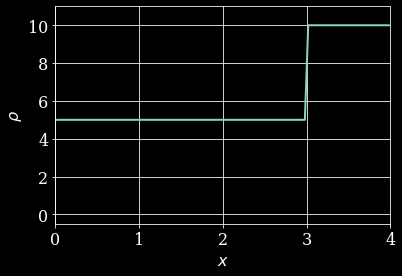

In [95]:
fig = plt.figure(figsize=(6.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.grid()
line = plt.plot(x, rho_values[0][0,:],
                    color='C0', linestyle='-', linewidth=2)[0]
plt.xlim(0.0, L)
plt.ylim(-0.5, 11.0)

In [96]:
def update_plot(n, stackrho_values):
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(stackrho_values[n,:])

In [99]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt*5, fargs=(stackrho_values,),
                               interval=200)
# Display the video.
HTML(anim.to_html5_video())